# Model Run: Pair learning
Version 1  
Low

Version 2  
Pregenerate list pair dataset

## Import Libs

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score


from model_model import SiameseNetwork
from model_configs import ModelDimConfigs, TrainingConfigs
from misc_tools import get_timestamp
from model_dataset import MelSpecTransform, DS_Tools
from model_dataset import PairRecDatasetPregen as ThisDataset
from model_filter import XpassFilter
from paths import *
from misc_progress_bar import draw_progress_bar
from misc_recorder import *

## Configure READ

In [2]:
READ = False

## Get Timestamp

In [3]:
if READ: 
    ts = "1113221926"
else: 
    ts = str(get_timestamp())
    # ts = "1120163222"

train_name = "pair-low"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)
print(f"{train_name}-{ts}")

pair-low-1120164825


In [4]:
stop_epoch = "99"
save_trainhist_name = "train.hst"
save_valhist_name = "val.hst"
save_valprec_name = "valprec.hst"
save_valrec_name = "valrec.hst"
save_valf_name = "valf.hst"

## Prepare Loss Recording

In [5]:
train_losses = ListRecorder(os.path.join(model_save_dir, save_trainhist_name))
valid_losses = ListRecorder(os.path.join(model_save_dir, save_valhist_name))

valid_precs = ListRecorder(os.path.join(model_save_dir, save_valprec_name))
valid_recs = ListRecorder(os.path.join(model_save_dir, save_valrec_name))
valid_fs = ListRecorder(os.path.join(model_save_dir, save_valf_name))

## Prepare Dataset

In [6]:
mytrans = MelSpecTransform(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, 
                            n_fft=TrainingConfigs.N_FFT, 
                            n_mels=TrainingConfigs.N_MELS, 
                            filter=XpassFilter(cut_off_upper=500))
ds = ThisDataset(train_cut_audio_, os.path.join(src_, "guide_mod.csv"), 
                 list_save_dir=model_save_dir, 
                 total_number=10000, transform=mytrans)

if not READ: 
    # use_len = int(0.01 * len(ds))
    # remain_len = len(ds) - use_len
    # use_ds, remain_ds = random_split(ds, [use_len, remain_len])
    use_ds = ds

    train_len = int(0.8 * len(use_ds))
    valid_len = len(use_ds) - train_len

    # Randomly split the dataset into train and validation sets
    train_ds, valid_ds = random_split(use_ds, [train_len, valid_len])

    # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
    # the saved train and valid separations will reflect this
    DS_Tools.save_indices(os.path.join(model_save_dir, "train.data"), train_ds.indices)
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid.data"), valid_ds.indices)
else: 
    train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.data"))
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.data"))

    train_ds = torch.utils.data.Subset(ds, train_ds_indices)
    valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)

train_loader = DataLoader(train_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=TrainingConfigs.LOADER_WORKER, 
                          collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                          shuffle=False, 
                          num_workers=TrainingConfigs.LOADER_WORKER, 
                          collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)
print(train_num, valid_num)

8000 2000


## Init Model

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
# NOTE: no need to mask the loss, because we don't do reconstruction. 

dimconf = ModelDimConfigs(
        rnn_in_size=TrainingConfigs.N_MELS, 
        lin_in_size_1=16, 
        lin_in_size_2=4, 
        lin_out_size_2=1
    )

model = SiameseNetwork(
    dimconf=dimconf
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_str = str(model)
model_txt_path = os.path.join(model_save_dir, "model.txt")

with open(model_txt_path, "w") as f:
    f.write(model_str)


In [10]:
model

SiameseNetwork(
  (rnn): SelfPackLSTM(
    (rnn): LSTM(64, 16, num_layers=2, batch_first=True)
    (extract): LastElementExtractor()
  )
  (fc): Sequential(
    (0): Linear(in_features=32, out_features=4, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

## Load Model if READ

In [11]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_raw_name = f"{stop_epoch}"
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

In [12]:
EPOCHS = 30
BASE = 0

In [13]:
def train(): 
    best_valid_loss = 1e9
    best_valid_loss_epoch = 0
    for epoch in range(BASE, BASE + EPOCHS):
        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, ((x_1, x_1_lens), (x_2, x_2_lens), y) in enumerate(train_loader):
            optimizer.zero_grad()
            
            x_1 = x_1.to(device)
            x_2 = x_2.to(device)
            y = torch.tensor(y, device=device, dtype=torch.float32)

            y_hat = model((x_1, x_2), (x_1_lens, x_2_lens))
            y_hat = y_hat.squeeze(dim=1)
            loss = criterion(y_hat, y)
            train_loss += loss.item()

            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # 这个函数计算的是全局梯度范数
            # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # parameters: an iterable of Variables that will have gradients normalized
            # max_norm: max norm of the gradients(阈值设定)
            # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()

            draw_progress_bar(idx, train_num, title="Train")

        train_losses.append(train_loss / train_num)

        last_model_name = f"{epoch}.pt"
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        valid_preds = []
        valid_targets = []
        for idx, ((x_1, x_1_lens), (x_2, x_2_lens), y) in enumerate(valid_loader):
            x_1 = x_1.to(device)
            x_2 = x_2.to(device)
            y = torch.tensor(y, device=device, dtype=torch.float32)

            y_hat = model((x_1, x_2), (x_1_lens, x_2_lens))
            y_hat = y_hat.squeeze(dim=1)
            loss = criterion(y_hat, y)
            valid_loss += loss.item()

            pred = model.predict_on_output(y_hat)

            valid_preds += pred.cpu().tolist()
            valid_targets += y.cpu().tolist()

            draw_progress_bar(idx, valid_num, title="Valid")

        avg_valid_loss = valid_loss / valid_num
        valid_losses.append(avg_valid_loss)
        valid_precs.append(precision_score(valid_targets, valid_preds, average="binary"))
        valid_recs.append(recall_score(valid_targets, valid_preds, average="binary"))
        valid_fs.append(f1_score(valid_targets, valid_preds, average="binary"))
        if avg_valid_loss < best_valid_loss: 
            best_valid_loss = avg_valid_loss
            best_valid_loss_epoch = epoch

        draw_learning_curve_and_accuracy(losses=(train_losses.get(), valid_losses.get(), best_valid_loss_epoch), 
                                         accs=(valid_precs.get(), valid_recs.get(), valid_fs.get()), 
                                         epoch=str(epoch))
        train_losses.save()
        valid_losses.save()
        valid_precs.save()
        valid_recs.save()
        valid_fs.save()
    
    return best_valid_loss_epoch

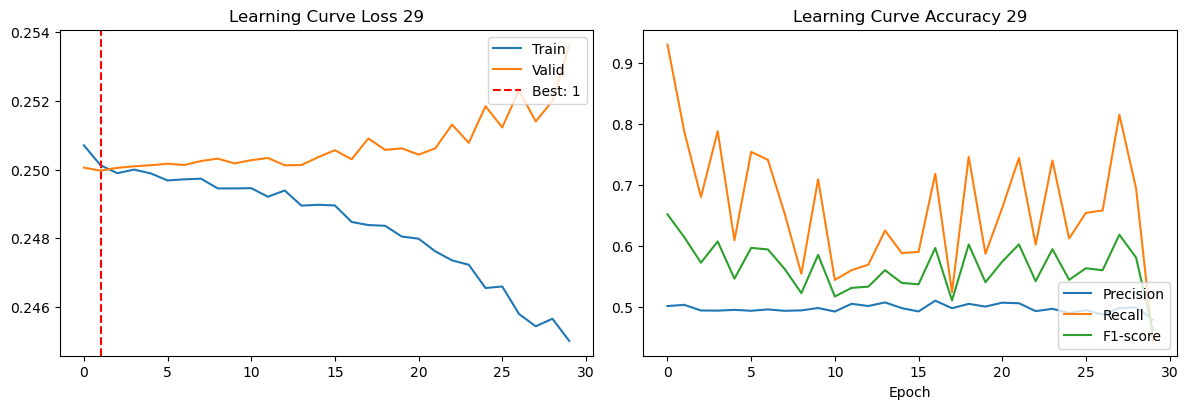

<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

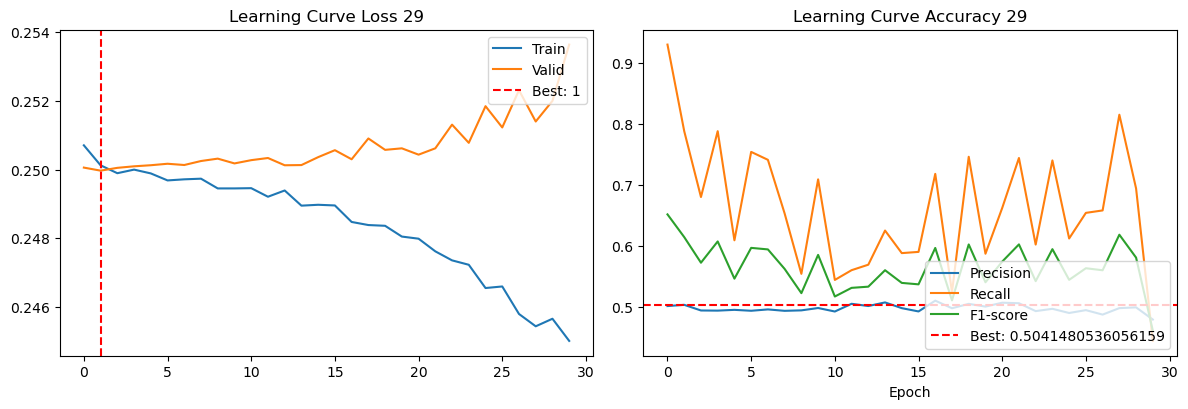

In [14]:
if __name__ == "__main__": 
    best_valid_loss_epoch = train()
    save_learning_curve_and_accuracy(losses=(train_losses.get(), valid_losses.get(), best_valid_loss_epoch), 
                                        accs=(valid_precs.get(), valid_recs.get(), valid_fs.get()), 
                                        epoch=str(BASE + EPOCHS - 1), 
                                        save_name=f"{model_save_dir}/vis.png")